# Skydio X2 Quadrotor

This notebook is focused on trajectory planning for quadrotor.

## Imports

In [1]:
"""Temporary fix for importing modules from parent directory"""

import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from varitop.misc import euler_rule, qconj, q2rm, quat_prod
from varitop.integrator import DelIntegrator as DI
from varitop.opti import Varitop

In [3]:
import numpy as np
from time import sleep

In [4]:
%%capture
!pip3 install robot_descriptions
from robot_descriptions.skydio_x2_mj_description import MJCF_PATH
from robot_descriptions.skydio_x2_description import URDF_PATH

In [5]:
from mujoco_simulator.model_builder import ModelBuilder
from mujoco_simulator.simulator import MujocoRender

In [ ]:
from darli.model import Functional
from darli.backend import CasadiBackend, JointType
from darli.backend.liecasadi.so3 import SO3
from darli.state_space import StateSpace
import casadi as cs

## Dynamics

In [7]:
model = Functional(CasadiBackend(URDF_PATH))

selector = np.array([[0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0],
                     [1.0, 1.0, 1.0, 1.0],
                     [-0.18, 0.18, 0.18, -0.18],
                     [0.14, 0.14, -0.14, -0.14],
                     [-0.0201, 0.0201, 0.0201, -0.0201]])

model.update_selector(selector)

Using the symbolical representation of the lagrangian
from the darli framework to build residuals

In [8]:
di = DI(
    nq = model.nq,
    nu = 4,
    free_body = True,
    selector = selector,
    lagrangian=model.lagrangian,
)

Unit quaternion constraint is required to satisfy the rotation quaternion

In [9]:
di.add_constraint(di.q[3:].T @ di.q[3:] - 1)

## Optimization Problem

40 nodes to optimize over DEL Integrator

In [10]:
vp = Varitop(integrator=di, nsteps=40)

In [11]:
tf = vp.parameter(1)
dt = tf / vp.ns
vp.dt = dt

In [12]:
q0 = vp.parameter(model.nq)
qf = vp.parameter(model.nq)

In [13]:
position_weight = vp.parameter(1)
acceleration_weight = vp.parameter(1)
velocity_weight = vp.parameter(1)
control_weight = vp.parameter(1)
control_max = vp.parameter(model.nu)

In [18]:
q = vp.q
u = vp.u
ns = vp.ns
dt = vp.dt

Cost function is comprised of two terms:
1. $x, y, z$ coordinates of the body should be equal to target
2. $|u|^2$

Flexibility of the indexing feature allows to specify
those constraints for each node separately

In [15]:
cost = 0 
for i in range(1, vp.ns):
    cost += position_weight*cs.sumsqr(q[:3,i] - qf[:3])*dt
    cost += control_weight*cs.sumsqr(u[:,i])*dt

In [17]:
vp.set_cost(cost)

Several constraints added to the system:
1. Minimal height is $q_z \geq 0.4$
2. $u_i \in \mathbb{U}$ i.e. control is within admissable bounds
3. Initial configuration is parametrized
4. Final configuration is parametrized

In [16]:
for i in range(1, vp.ns):
    vp.bounded(np.zeros(model.nu), u[:, i], control_max)
    vp.subject_to(q[2, i] >= 0.4)
    
vp.set_initial_configuration(q0)
vp.set_terminal_configuration(qf)

## Solution

Initial values for all parameters are specified

In [18]:
Q_INIT = np.array([0, 0, 1.5, 0,0,0, 1])
quat_random = np.random.rand(4)
quat_random /= np.linalg.norm(quat_random)
Q_INIT[3:] = quat_random
Q_FINAL = np.array([0, 0., 2.5, 0, 0, 0, 1])
Q_FINAL[:3] += np.random.randn(3)

t_final = 3

vp.set_parameter(tf, t_final)
vp.set_parameter(control_max, 50*np.ones(model.nu) )
vp.set_parameter(q0, Q_INIT)
vp.set_parameter(qf, Q_FINAL)

vp.set_parameter(position_weight[0], 5)
vp.set_parameter(velocity_weight[0], 10)
vp.set_parameter(acceleration_weight[0], 5)
vp.set_parameter(control_weight[0], 5)

vp.set_initial(q[3:,:], np.array([Q_INIT[3:]]*(vp.ns+1)).T)
vp.set_initial(q[:3,:], np.linspace(Q_INIT[:3], Q_FINAL[:3], vp.ns+1).T)

ren.set_state(Q_INIT)
ren.markers[vp.ns+1](position=Q_FINAL[:3],
                color=[1, 0, 0, 0.5],
                size=0.04)
ren.markers[vp.ns+2](position=Q_INIT[:3],
                color=[0, 1, 0, 0.5],
                size=0.04)


In [19]:

sol = vp.solve()
q_opt = vp.value(vp.q)
u_opt = vp.value(vp.u)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     6137
Number of nonzeros in inequality constraint Jacobian.:      195
Number of nonzeros in Lagrangian Hessian.............:     4179

Total number of variables............................:      487
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      365
Total number of inequality c

# Visualisation

In [20]:
ns = vp.ns

In [6]:
model_wrapper = ModelBuilder(MJCF_PATH)
model_wrapper.add_arena()
model_wrapper.build()
ren = MujocoRender(model=model_wrapper, 
                   start=True, 
                   convention='pin')
Q_INIT = np.array([0, 0, 1.0, 0, 0, 0,1])
ren.set_state(Q_INIT)

Process render is starting!


In [22]:
for i in range(ns+1):
    ren.set_state(q_opt[:, i])

    for j in range(i):
        ren.markers[j](position=q_opt[:3, j],
                       color=[0, 0, 1, 0.5],
                       size=j*0.02/ns + 0.01)

    ren.markers[ns+1](position=Q_FINAL[:3],
                      color=[1, 0, 0, 0.5],
                      size=0.04)
    ren.markers[ns+2](position=Q_INIT[:3],
                    color=[0, 1, 0, 0.5],
                    size=0.04)
    sleep(t_final/ns)

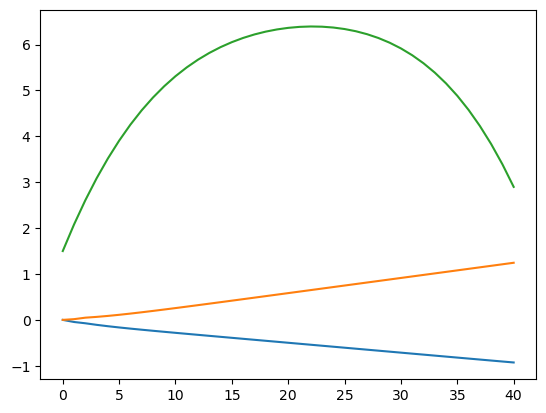

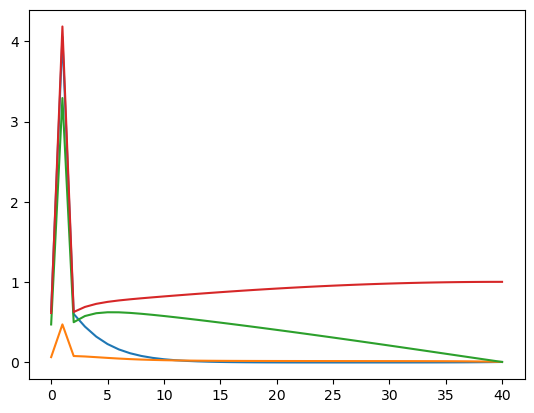

In [23]:
import matplotlib.pyplot as plt
plt.plot(q_opt[:3,:].T)
plt.show()

plt.plot(q_opt[3:7,:].T)
plt.show()


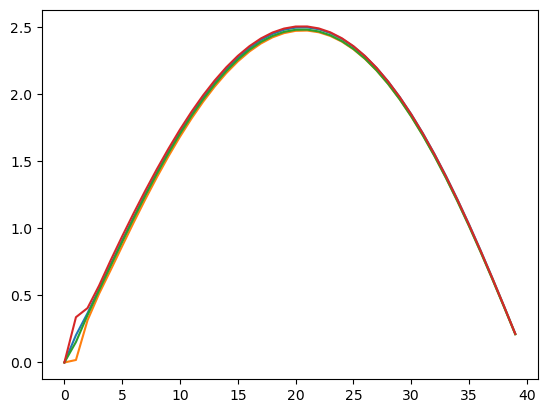

In [24]:

plt.plot(u_opt.T)
plt.show()

In [25]:
q_opt.shape

(7, 41)

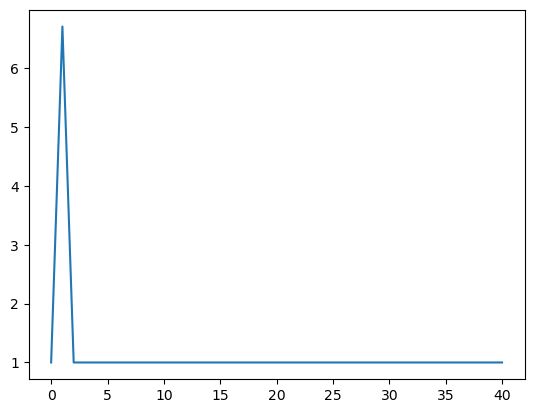

In [26]:
plt.plot(np.linalg.norm(q_opt[3:7, :].T, axis=1))
plt.show()

In [27]:
np.linalg.norm(q_opt[3:7,:].T, axis = 1)

array([1.        , 6.71236855, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])